In [3]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length = len(uploaded[fn])
  ))

!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 66 bytes


In [4]:
!kaggle datasets download -d uraninjo/augmented-alzheimer-mri-dataset

 98% 372M/380M [00:06<00:00, 84.1MB/s]
100% 380M/380M [00:06<00:00, 60.1MB/s]


In [5]:
from zipfile import ZipFile
file_name= "/content/augmented-alzheimer-mri-dataset.zip"
with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('done')

done


In [6]:
import tensorflow as tf
import os, glob
import cv2
from tqdm._tqdm_notebook import tqdm_notebook as tqdm
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Convolution2D, Dropout, Dense, MaxPooling2D,BatchNormalization
from keras.layers import Flatten

In [7]:
# x contains images from the folders
# y contains labels
x = []
y = []

# Append all the images and labels to the arrays
os.chdir('/content/AugmentedAlzheimerDataset/NonDemented')
for i in tqdm(os.listdir()):
  img = cv2.imread(i)
  img = cv2.resize(img,(224,224))
  x.append(img)
  y.append("NonDemented")
os.chdir('/content/AugmentedAlzheimerDataset/VeryMildDemented')
for i in tqdm(os.listdir()):
  img = cv2.imread(i)
  img = cv2.resize(img,(224,224))
  x.append(img)
  y.append("VeryMildDemented")
os.chdir('/content/AugmentedAlzheimerDataset/MildDemented')
for i in tqdm(os.listdir()):
  img = cv2.imread(i)
  img = cv2.resize(img,(224,224))
  x.append(img)
  y.append("MildDemented")
os.chdir('/content/AugmentedAlzheimerDataset/ModerateDemented')
for i in tqdm(os.listdir()):
  img = cv2.imread(i)
  img = cv2.resize(img,(224,224))
  x.append(img)
  y.append("ModerateDemented")

print(y)

  0%|          | 0/9600 [00:00<?, ?it/s]

  0%|          | 0/8960 [00:00<?, ?it/s]

  0%|          | 0/8960 [00:00<?, ?it/s]

  0%|          | 0/6464 [00:00<?, ?it/s]

['NonDemented', 'NonDemented', 'NonDemented', 'NonDemented', 'NonDemented', 'NonDemented', 'NonDemented', 'NonDemented', 'NonDemented', 'NonDemented', 'NonDemented', 'NonDemented', 'NonDemented', 'NonDemented', 'NonDemented', 'NonDemented', 'NonDemented', 'NonDemented', 'NonDemented', 'NonDemented', 'NonDemented', 'NonDemented', 'NonDemented', 'NonDemented', 'NonDemented', 'NonDemented', 'NonDemented', 'NonDemented', 'NonDemented', 'NonDemented', 'NonDemented', 'NonDemented', 'NonDemented', 'NonDemented', 'NonDemented', 'NonDemented', 'NonDemented', 'NonDemented', 'NonDemented', 'NonDemented', 'NonDemented', 'NonDemented', 'NonDemented', 'NonDemented', 'NonDemented', 'NonDemented', 'NonDemented', 'NonDemented', 'NonDemented', 'NonDemented', 'NonDemented', 'NonDemented', 'NonDemented', 'NonDemented', 'NonDemented', 'NonDemented', 'NonDemented', 'NonDemented', 'NonDemented', 'NonDemented', 'NonDemented', 'NonDemented', 'NonDemented', 'NonDemented', 'NonDemented', 'NonDemented', 'NonDemen

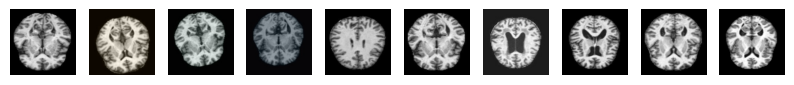

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for i in range(10):
  plt.subplot(1, 10, i+1)
  plt.imshow(x[i], cmap="gray")
  plt.axis('off')
plt.show()

In [9]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state = 42)
print("Shape of an image in x train: ", x_train[0].shape)
print("Shape of an image in x test: ", x_test[0].shape)

Shape of an image in x train:  (224, 224, 3)
Shape of an image in x test:  (224, 224, 3)


In [10]:
le = preprocessing.LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

In [11]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes = None)
y_test = tf.keras.utils.to_categorical(y_test, num_classes = None)
y_train = np.array(y_train)
x_train = np.array(x_train)
y_test = np.array(y_test)
x_test = np.array(x_test)

In [12]:
print("x_train Shape: ", x_train.shape)
print("x_test Shape: ", x_test.shape)
print("y_train Shape: ", y_train.shape)
print("y_test Shape: ", y_test.shape)

x_train Shape:  (23788, 224, 224, 3)
x_test Shape:  (10196, 224, 224, 3)
y_train Shape:  (23788, 4)
y_test Shape:  (10196, 4)


In [13]:
from keras.applications import vgg16

img_rows, img_cols = 224, 224

vgg = vgg16.VGG16(weights = 'imagenet',
                  include_top= False,
                  input_shape = (img_rows, img_cols, 3))
for layer in vgg.layers:
  layer.trainable = False

for (i,layer) in enumerate(vgg.layers):
  print(str(i) + " " + layer.__class__.__name__, layer.trainable)

58889256/58889256 [==============================] - 1s 0us/step
0 InputLayer False
1 Conv2D False
2 Conv2D False
3 MaxPooling2D False
4 Conv2D False
5 Conv2D False
6 MaxPooling2D False
7 Conv2D False
8 Conv2D False
9 Conv2D False
10 MaxPooling2D False
11 Conv2D False
12 Conv2D False
13 Conv2D False
14 MaxPooling2D False
15 Conv2D False
16 Conv2D False
17 Conv2D False
18 MaxPooling2D False


In [14]:
def lw(bottom_model, num_classes):
  """creates the top or head of the model that will be placed ontop of the bottom layers"""

  top_model = bottom_model.output
  top_model = GlobalAveragePooling2D()(top_model)
  top_model = Dense(1024, activation='relu')(top_model)
  top_model = Dense(1024, activation='relu')(top_model)
  top_model = Dense(512, activation='relu')(top_model)
  top_model = Dense(num_classes, activation='softmax')(top_model)
  return top_model

In [15]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D

from keras.models import Model

num_classes = 2

FC_Head = lw(vgg, num_classes)

model = Model(inputs = vgg.input, outputs = FC_Head)

print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [16]:
model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
history = model.fit(x_train, y_train,
                    epochs = 5,
                    verbose = 1,
                    initial_epoch=0)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label="training accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation accuracy")
plt.title('Training and validation accuracy')
plt.legend(loc=0)
pt.figure()

plt.show()